In [30]:
from urllib.request import urlopen
import urllib.error as errors
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [273]:
def get_tables(cricinfo_id, verbose=False):
    print(cricinfo_id)
    url = "http://stats.espncricinfo.com/ci/engine/player/{0}.html?class=2;template=results;type=batting;view=innings".format(cricinfo_id)
    print(url)
    try:
        html = urlopen(url)
        soup = BeautifulSoup(html, 'lxml')
        tables = soup.find_all("table")
        return tables
    except errors.HTTPError as err:
        if verbose:
            print(err)
        return None
    

def get_name(cricinfo_id, no_space=False):
    url = "http://www.espncricinfo.com/england/content/player/{0}.html".format(cricinfo_id)
    try:
        html = urlopen(url)
    except errors.HTTPError as err:
        return "NULL"
    soup = BeautifulSoup(html, 'lxml')
    name  = soup.find_all("title")[0].text.split("-")[0].strip()
    if "'" in name:
        name = name.replace("'", "")
    if no_space:
        return name.replace(" ", "_").lower()
    else:
        return name

In [148]:
get_name(298438, True)

'jason_roy'

In [158]:

# for i,table in enumerate(tables):
#    print(i,table)
def get_column_names(tables):
    column_names = []
    for column in tables[3].find_all("tr")[0].find_all("th"):
        column_names.append(column.text)
    return column_names

In [292]:
def str_to_float(row_dict):
    for col in ["Mins", "BF", "4s", "6s", "SR", "Pos", "Inns"]:
        if row_dict[col] == "-":
            row_dict[col] = -1
        row_dict[col] = float(row_dict[col])
    return row_dict

def get_data(tables, column_names):
    vals = []
    for i,row in enumerate(tables[3].find_all("tr")[1:]):
        row_dict = {col_name: 0 for col_name in column_names}
        for j,col in enumerate(row.find_all("td")):
            row_dict[column_names[j]] = col.text
        if not row_dict["Runs"] == "DNB" and not row_dict["Runs"] == "TDNB" and not row_dict["Runs"] == "sub":
            if "*" in row_dict["Runs"]:
                row_dict["Notout"] = 1
                row_dict["Runs"] = float(row_dict["Runs"].replace("*",""))
            else:
                row_dict["Notout"] = 0
                row_dict["Runs"] = float(row_dict["Runs"])
            
            row_dict = str_to_float(row_dict)
            row_dict["Inns"] = int(row_dict["Inns"])
            vals.append(row_dict)
    df = pd.DataFrame(vals)
    return df

<Figure size 1080x648 with 0 Axes>

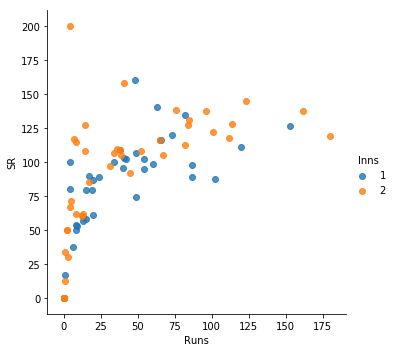

In [5]:
plt.figure(figsize=(15,9))
sns.lmplot(data=df, x="Runs", y="SR", hue="Inns", fit_reg=False)

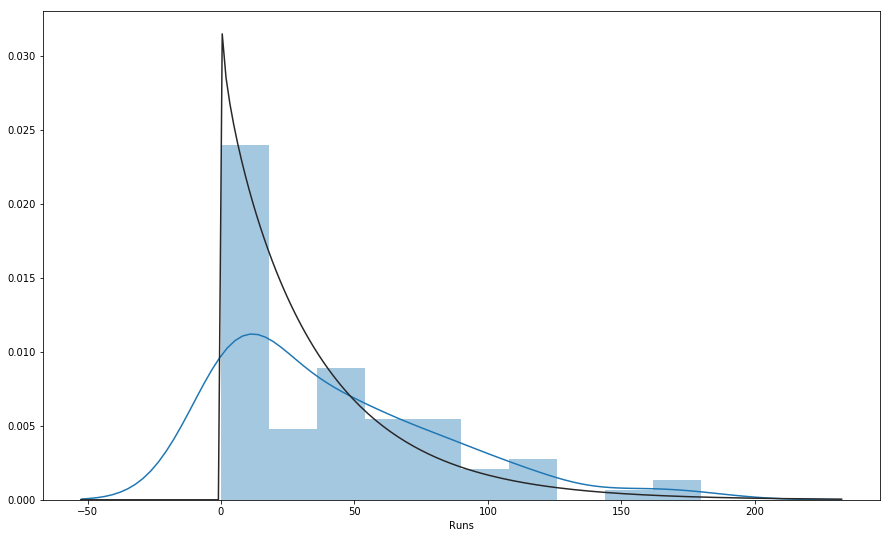

In [8]:
from scipy import stats
plt.figure(figsize=(15,9))
sns.distplot(df["Runs"], fit=stats.chi2, bins=10)

In [96]:
fit_result = stats.chi2.fit(df["Runs"])

In [99]:
fit_result

(1.6699622966216041, -9.103029092690246e-26, 16.479070010705748)

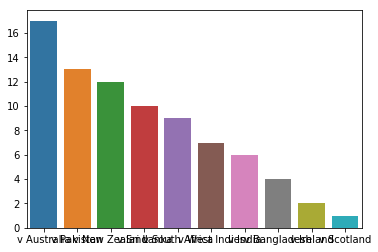

In [155]:

counts = df["Opposition"].value_counts()
sns.barplot(x=counts.keys(), y=counts.get_values())
counts.get_values()

def plot_bar_string(df, key, figsize=(15,9)):
    counts = df[key].value_counts()
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=counts.keys(), y=counts.get_values())
    
    

In [32]:
import sqlite3


In [162]:
connection = sqlite3.connect("test_table.db") 


In [163]:
crsr = connection.cursor() 

In [280]:
print(df.columns)
type_map = {np.float64: "FLOAT", 
           np.int64: "INT",
           str: "VARCHAR(255)"}
def create_player_table(cursor, name, df):
    sql_command = "CREATE TABLE IF NOT EXISTS {0} (".format(name)
    for i,col in enumerate(df.columns[1:]):
        sql_command += "'{0}' {1}".format(col.replace(" ", "_"), type_map[type(df[col][0])])
        if i != len(df.columns[1:])-1:
            sql_command += ", "
    sql_command += ");"
    print(sql_command)
    cursor.execute(sql_command)

    

# crsr.execute(sql_command)

Index(['', '4s', '6s', 'BF', 'Dismissal', 'Ground', 'Inns', 'Mins', 'Notout',
       'Opposition', 'Pos', 'Runs', 'SR', 'Start Date'],
      dtype='object')


In [113]:
create_player_table(crsr, "test", df)
connection.commit()

0
1
2
3
4
5
6
7
8
9
10
11
12
CREATE TABLE test ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 'Start_Date' VARCHAR(255));


In [151]:
def insert_player_data(cursor, name, df):
    for index, row in df.iterrows():
        sql_command = "INSERT INTO {0} VALUES (".format(name)
        for i,col in enumerate(df.columns[1:]):
            if type(row[col]) == str:
                sql_command += '"{0}"'.format(row[col])
            else:
                sql_command += "{0}".format(row[col])
            if i != len(df.columns[1:])-1:
                sql_command += ", "
        sql_command += ");"
        crsr.execute(sql_command) 

In [152]:
insert_player_data(crsr, "test", df)
connection.commit()

In [288]:

def fill_database(cricinfo_id):
    tables = get_tables(cricinfo_id=cricinfo_id, verbose=True)
    if tables:
        print(cricinfo_id,get_name(cricinfo_id=cricinfo_id, no_space=True))
        column_names= get_column_names(tables=tables)
        print(column_names)
        if len(column_names) == 0:
            print("No ODI data!")
            return None
        df = get_data(column_names=column_names, tables=tables)
        if len(df) == 0:
            print("Didnt bat")
            return None
        create_player_table(cursor=crsr, name=get_name(cricinfo_id=cricinfo_id, no_space=True), df=df)
        insert_player_data(cursor=crsr, name=get_name(cricinfo_id=cricinfo_id, no_space=True), df=df)
        connection.commit()

In [289]:
url = "http://www.espncricinfo.com/england/content/player/caps.html?country=1;class=2"
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
england_player_id = []

for a in range(1,255):
    tables = soup.find_all("div")[17].find_all("ul")[a].find_all("li")[1].find_all("a")[0]
    england_player_id.append(int(tables.get("href").split("/")[-1].split(".")[0]))

In [293]:
for number in england_player_id[171:]:
    print(number)
    fill_database(number)

8608
8608
http://stats.espncricinfo.com/ci/engine/player/8608.html?class=2;template=results;type=batting;view=innings
8608 james_anderson
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS james_anderson ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 'Start_Date' VARCHAR(255));
14054
14054
http://stats.espncricinfo.com/ci/engine/player/14054.html?class=2;template=results;type=batting;view=innings
14054 steve_harmison
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS steve_harmison ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' F

16281
16281
http://stats.espncricinfo.com/ci/engine/player/16281.html?class=2;template=results;type=batting;view=innings
16281 jon_lewis
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS jon_lewis ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 'Start_Date' VARCHAR(255));
21650
21650
http://stats.espncricinfo.com/ci/engine/player/21650.html?class=2;template=results;type=batting;view=innings
21650 chris_tremlett
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS chris_tremlett ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 

23460
23460
http://stats.espncricinfo.com/ci/engine/player/23460.html?class=2;template=results;type=batting;view=innings
23460 luke_wright
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS luke_wright ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 'Start_Date' VARCHAR(255));
17185
17185
http://stats.espncricinfo.com/ci/engine/player/17185.html?class=2;template=results;type=batting;view=innings
17185 phil_mustard
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS phil_mustard ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 

310519
310519
http://stats.espncricinfo.com/ci/engine/player/310519.html?class=2;template=results;type=batting;view=innings
310519 scott_borthwick
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS scott_borthwick ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 'Start_Date' VARCHAR(255));
311158
311158
http://stats.espncricinfo.com/ci/engine/player/311158.html?class=2;template=results;type=batting;view=innings
311158 ben_stokes
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS ben_stokes ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 

349853
349853
http://stats.espncricinfo.com/ci/engine/player/349853.html?class=2;template=results;type=batting;view=innings
349853 zafar_ansari
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
Didnt bat
298438
298438
http://stats.espncricinfo.com/ci/engine/player/298438.html?class=2;template=results;type=batting;view=innings
298438 jason_roy
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS jason_roy ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 'Start_Date' VARCHAR(255));
296597
296597
http://stats.espncricinfo.com/ci/engine/player/296597.html?class=2;template=results;type=batting;view=innings
296597 james_vince
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'O

236489
236489
http://stats.espncricinfo.com/ci/engine/player/236489.html?class=2;template=results;type=batting;view=innings
236489 dawid_malan
['Runs', 'Mins', 'BF', '4s', '6s', 'SR', 'Pos', 'Dismissal', 'Inns', '', 'Opposition', 'Ground', 'Start Date', '']
CREATE TABLE IF NOT EXISTS dawid_malan ('4s' FLOAT, '6s' FLOAT, 'BF' FLOAT, 'Dismissal' VARCHAR(255), 'Ground' VARCHAR(255), 'Inns' INT, 'Mins' FLOAT, 'Notout' INT, 'Opposition' VARCHAR(255), 'Pos' FLOAT, 'Runs' FLOAT, 'SR' FLOAT, 'Start_Date' VARCHAR(255));
